In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from deeprobust.graph.defense import GCN
from deeprobust.graph.targeted_attack import FGA
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from tqdm import tqdm
import argparse
from experiments import split_dataset
from DistributedDefense import TwoPartyCNGCN
import networkx as nx
from scipy.sparse import csr_matrix
import Mahsa_backdoor_V0 as backdoor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

In [2]:
################################# Attack repeatedly ###############################
# Define the number of repeats
num_repeats = 5
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset)
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems

for _ in range(num_repeats):
    
    #############################  preprocessing ############################
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    #split idx_test into two parts randomly
    test_size = 0.10  # 10% for test_attack, 90% for test_clean
    # test_size = 1- 1 / len(idx_test)  # 1 node for test_attack, the rest for test_clean

    idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=42)


    # Split graph into two graphs 
    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

    ############################ tarin model initially and test accuracy ###########################
    # Perform evaluation before attack to find the baseline accuracy

    # Train GCN model 
    # 1. Model definition
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    # 2. Train model - patience= number of epochs to wait before early stopping , train_iters= number of iterations
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    #model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200,metric=metric,
               #object=object, initialize=True, verbose=False )
    # 3. Evaluate model
    model.eval()
    output = model.test(idx_test)
    #acc_test = accuracy(output, labels, idx_test)

    accuracies = model.test(idx_test) 
    print("Test accuracy: ", accuracies)

    output_1 = model.test(idx_test_attack)
    output_2 = model.test(idx_test_clean)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)

    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    ################################ Mahsa attack ##############################
    # Perform the attack
    # version 0: attack on the whole graph - on idx_test_attack nodes

    modified_adj1 =  adj1.copy()

    # Create a NetworkX graph from the adjacency matrix
    graph = nx.from_scipy_sparse_array(modified_adj1)

    # Add labels to the graph
    for node_id, label in enumerate(labels):
        graph.nodes[node_id]['label'] = label
    # print(f"lenght of the labels : {len(labels)}") 
    print(f"graph edges : {graph.number_of_edges()}")
    print(f"graph nodes : {graph.number_of_nodes()}")
    # Set the budget for the attack
    budget = 5

    #attacked_graph is initially set to graph, and then updated after each attack
    # This means that each attack is performed on the graph resulting from the previous attacks.
    attacked_graph = graph
    for target_node in idx_test_attack:
        non_neighbor_opposit = backdoor.find_non_neighbor_opposit_label(attacked_graph, target_node)
        max_same_min_opposit_label_neighbors = backdoor.find_max_same_min_opposit_label_neighbors(attacked_graph, non_neighbor_opposit)
        nodes_for_attack = backdoor.nodes_for_attack(attacked_graph, target_node, max_same_min_opposit_label_neighbors, budget)
        attacked_graph = backdoor.insert_edge(attacked_graph, target_node, nodes_for_attack)
        backdoor.evaluate_graph(attacked_graph, nodes_for_attack, target_node, budget)

    # Convert the graph to a CSR matrix
    modified_adj1 =backdoor.convert(attacked_graph)
    print(attacked_graph)

    ################################ evaluation after attack ##############################
    # accuracy after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    #data = data.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    output = model.test(idx_test)

    #acc_test = accuracy(output, labels, idx_test)

    output_1 = model.test(idx_test_attack)
    output_2 = model.test(idx_test_clean)

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set: ", accuracy_test_attack_2)
    print("Test accuracy on clean set: ", accuracy_test_clean_2)

    ############################ Crypto'Graph defense ###########################
    # Perform Crypto'Graph distributed defense

    threshold = 2               # threshold for dropping dissimilar edges
    metric = "neighbors"        # metric for dropping dissimilar edges (neighbors, jaccard, cosine)
    object = "links"            # object for defense (links, features)

    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                            device=device)
    model.fit(modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
                train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)  #accuracy of the model after the defense on all the test data - (all the nodes)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_3)
    print("Test accuracy on clean set: ", accuracy_test_clean_3)

    # At the end of each repeat, append the accuracy values to the lists:
    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)



####################### Standard deviation values ############################
# Calculate the standard deviation of the accuracy values:
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

print("Standard deviation of test accuracy on attack set 1: ", accuracy_test_attack_1_std)
print("Standard deviation of test accuracy on clean set 1: ", accuracy_test_clean_1_std)
print("Standard deviation of test accuracy on attack set 2: ", accuracy_test_attack_2_std)
print("Standard deviation of test accuracy on clean set 2: ", accuracy_test_clean_2_std)
print("Standard deviation of test accuracy on attack set 3: ", accuracy_test_attack_3_std)
print("Standard deviation of test accuracy on clean set 3: ", accuracy_test_clean_3_std)

# Save the standard deviation values to a file
with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)


####################### Average accuracy values ############################
# Calculate the average accuracy values:
accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)

print("Average test accuracy on attack set 1: ", accuracy_test_attack_1_avg)
print("Average test accuracy on clean set 1: ", accuracy_test_clean_1_avg)
print("Average test accuracy on attack set 2: ", accuracy_test_attack_2_avg)
print("Average test accuracy on clean set 2: ", accuracy_test_clean_2_avg)
print("Average test accuracy on attack set 3: ", accuracy_test_attack_3_avg)
print("Average test accuracy on clean set 3: ", accuracy_test_clean_3_avg)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)
    
##################################

Loading polblogs dataset...
Selecting 1 largest connected components


C:\Users\mahsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\deeprobust\graph\utils.py:356: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(sparseconcat.t(),sparsedata,torch.Size(sparse_mx.shape))


Test set results: loss= 0.1949 accuracy= 0.9458
Test set results: loss= 0.1949 accuracy= 0.9458
Test accuracy:  0.9458077709611452
Test set results: loss= 0.1361 accuracy= 0.9694
Test set results: loss= 0.2015 accuracy= 0.9432
Test set results: loss= 0.1361 accuracy= 0.9694
Test set results: loss= 0.2015 accuracy= 0.9432
Test accuracy on attack set:  0.9693877551020408
Test accuracy on clean set:  0.9431818181818182
graph edges : 16714
graph nodes : 1222
Edge insertion done and 5 edges has been inserted between 590 and : [(421, 0.24050632911392406, 14), (47, 0.9205776173285198, 12), (496, 0.8503649635036497, 12), (565, 0.7981651376146789, 12), (214, 0.18421052631578946, 11)]
Edge insertion done and 5 edges has been inserted between 618 and : [(496, 0.8472727272727273, 69), (565, 0.7945205479452054, 56), (126, 0.8689458689458689, 55), (47, 0.9172661870503597, 48), (583, 0.8195488721804511, 45)]
Edge insertion done and 5 edges has been inserted between 346 and : [(945, 0.7898550724637681

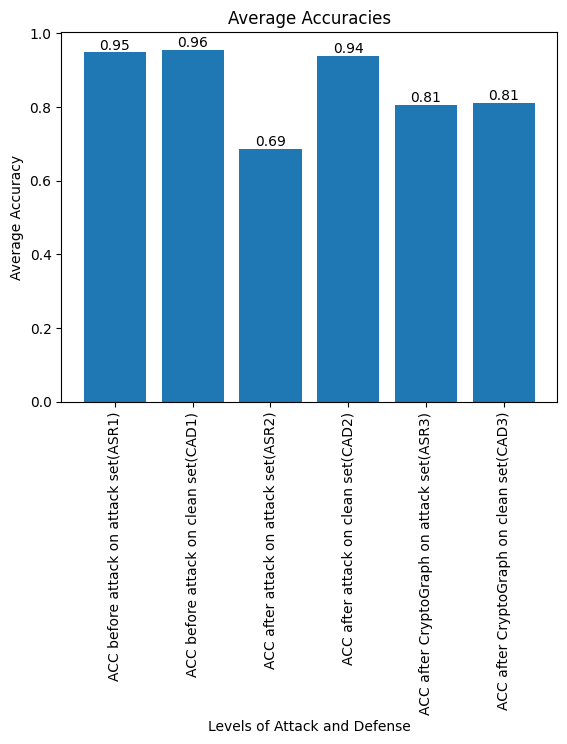

In [3]:
################################# Plot the results ###############################
# Define the labels and values for the bar chart

import pickle

with open('variables.pkl', 'rb') as f:
    accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, \
    accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, \
    accuracy_test_attack_3_avg, accuracy_test_clean_3_avg = pickle.load(f)
    
labels = ['ACC before attack on attack set(ASR1)', 'ACC before attack on clean set(CAD1)', 
          'ACC after attack on attack set(ASR2)', 'ACC after attack on clean set(CAD2)', 
          'ACC after CryptoGraph on attack set(ASR3)', 'ACC after CryptoGraph on clean set(CAD3)']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]

# Create the bar chart
bars = plt.bar(labels, values)

# Add a title and labels to the axes
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')

# Make the x-labels vertical
plt.xticks(rotation='vertical')

# Add exact values on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Display the chart
plt.show()



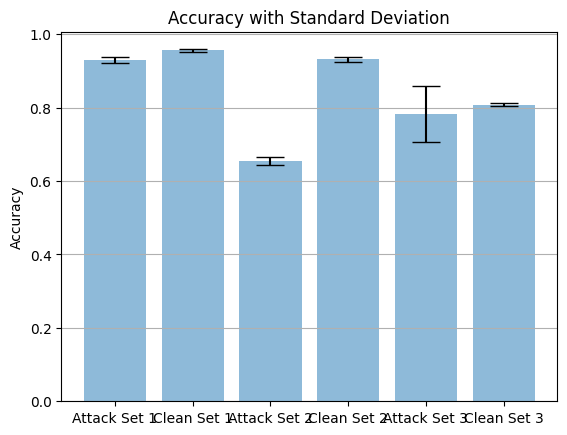

In [44]:
# Define the labels for the bars
labels = ['Attack Set 1', 'Clean Set 1', 'Attack Set 2', 'Clean Set 2', 'Attack Set 3', 'Clean Set 3']

# Define the mean values
means = [np.mean(values) for values in [accuracy_test_attack_1_values, accuracy_test_clean_1_values, 
                                        accuracy_test_attack_2_values, accuracy_test_clean_2_values, 
                                        accuracy_test_attack_3_values, accuracy_test_clean_3_values]]

# Define the standard deviation values
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Create the bar plot with error bars
ax.bar(labels, means, yerr=std_devs, align='center', alpha=0.5, ecolor='black', capsize=10)

# Customize the plot
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy with Standard Deviation')
ax.yaxis.grid(True)

# Show the plot
plt.show()

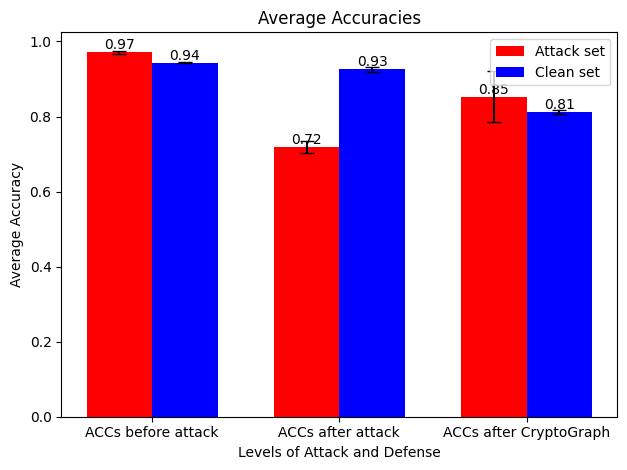

In [3]:
labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]

# Define the x-coordinates of the bars and the width of the bars
x = np.arange(len(labels)//2)
width = 0.35

# # Create the bar chart
# bars1 = plt.bar(x - width/2, values[::2], width, label='Attack set', color='red')
# bars2 = plt.bar(x + width/2, values[1::2], width, label='Clean set', color='blue')

# Create the bar chart with error bars
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)

# Add a title and labels to the axes
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')

# Make the x-labels vertical
plt.xticks(x, labels[::2])

# Add a legend
plt.legend()

# Add exact values on each bar
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adjust the layout to prevent the labels from being cut off
plt.tight_layout()

# Display the chart
plt.show()